# Analysis on factors affecting Yulu's electric bikes

**About Yulu**  
Yulu is India’s leading micro-mobility service provider, which offers unique vehicles for the daily commute. Starting off as a mission to eliminate traffic congestion in India, Yulu provides the safest commute solution through a user-friendly mobile app to enable shared, solo and sustainable commuting.  

Yulu has recently suffered considerable dips in its revenues. They have contracted a consulting company to **understand the factors on which the demand for these shared electric cycles depends. Specifically, they want to understand the factors affecting the demand for these shared electric cycles in the Indian market.**

#### **Relevant Libraries**

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Stats
from scipy.stats import ttest_ind # 2 Sample T-test
from scipy.stats import f_oneway # ANOVA test
from scipy.stats import kruskal # to Non-parametric test
from scipy.stats import kstest # To check the normality of the data
from scipy.stats import levene
from scipy.stats import shapiro
from statsmodels.api import qqplot # to graphical check normality of the data
from scipy.stats import chi2_contingency

#### **Raw Dataset**

In [6]:
raw_df = pd.read_csv('bike_sharing.csv')
raw_df

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


**Insights**
* Raw dataset contain 10886 rows and 12 columns
* Column Profiling:
    - datetime: datetime (hourly)
    - season: season (1: spring, 2: summer, 3: fall, 4: winter)
    - holiday: whether day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
    - workingday: if day is neither weekend nor holiday is 1, otherwise is 0.
    - weather:
      Clear, Few clouds, partly cloudy, partly cloudy
      Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
      Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
      Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
    - temp: temperature in Celsius
    - atemp: feeling temperature in Celsius
    - humidity: humidity
    - windspeed: wind speed
    - casual: count of casual users
    - registered: count of registered users
    - count: count of total rental bikes including both casual and registered

#### **Dataset Description**

In [9]:
# Dataset shape
print(f'shape of the raw dataset is -> {raw_df.shape}')
print('-'*100)

# Missing values
print(f'missing value -> {raw_df.isna().sum().sum()}')
print('-'*100)

# Duplicate records
print(f'duplicate records -> {raw_df.duplicated().sum()}')
print('-'*100)

# Columns datatype
print(raw_df.info())
print('-'*100)

shape of the raw dataset is -> (10886, 12)
----------------------------------------------------------------------------------------------------
missing value -> 0
----------------------------------------------------------------------------------------------------
duplicate records -> 0
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  regist

**Insights**
* No missing values in the dataset.
* No duplicate rows found.
* Dataset shape is (10886, 12)

#### **Feature Engneering**

In [12]:
# Copy data
df_clean = raw_df.copy()

# Convert datetime to pd.datetime
df_clean['datetime'] = pd.to_datetime(df_clean['datetime'])

# Convert nominal data to categorical
df_clean['season'] = df_clean['season'].map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})
df_clean['weather'] = df_clean['weather'].map({1:'clear', 2:'cloudy', 3:'rain', 4:'thunderstorm'})

# Convert Binary Data in Categorical
df_clean['workingday'] = df_clean['workingday'].map({1:'Yes', 0:'No'})
df_clean['holiday'] = df_clean['holiday'].map({1:'Yes', 0:'No'})

# time of the day columns added 
bins = [0, 4, 11, 16, 20, 23]
labels = ['night', 'morning', 'afternoon', 'evening', 'night']

df_clean['timeofday'] = pd.cut(df_clean['datetime'].dt.hour,
                               bins=bins, labels=labels,
                               include_lowest=True, ordered=False).astype('str')
# re-structured
df_clean = df_clean[['datetime', 'season', 'weather', 'timeofday', 'holiday', 'workingday',
                     'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']]

# round values to decimal 2
df_clean = df_clean.round(2)

# Cleaned data info
print(df_clean.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  object        
 2   weather     10886 non-null  object        
 3   timeofday   10886 non-null  object        
 4   holiday     10886 non-null  object        
 5   workingday  10886 non-null  object        
 6   temp        10886 non-null  float64       
 7   atemp       10886 non-null  float64       
 8   humidity    10886 non-null  int64         
 9   windspeed   10886 non-null  float64       
 10  casual      10886 non-null  int64         
 11  registered  10886 non-null  int64         
 12  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(4), object(5)
memory usage: 1.1+ MB
None


**Insights**
* In feature engneering process, object datetime has been changed to pd.datetime for easy datetime calculations.
* Nominal data in season and weather column does not hold any meaning therefore converted to categorical data.
* Time of the day column added using datetime hours.
* Cleaned dataset shape is 10886 rows and 13 columns.

#### **Exploratory Data Analysis**

##### **Univariate Analysis**

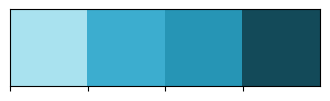

In [16]:
# report colors
single_color= "#3CADCF"
yulu_palette = ["#A9E2EF","#3CADCF","#2695B5","#134A59"]
sns.palplot(yulu_palette)

In [17]:
# Copy dataset
df = df_clean.copy()

In [18]:
# Descriptive Statistics
df.describe(include='all').round(2)

,datetime,season,weather,timeofday,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886,10886,10886,10886,10886,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00,10886.00
unique,NaN,4,4,4,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,winter,clear,night,No,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,2734,7192,3600,10575,7412,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2011-12-27 05:56:22.399411968,NaN,NaN,NaN,NaN,NaN,20.23,23.65,61.89,12.80,36.02,155.55,191.57
min,2011-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,0.82,0.76,0.00,0.00,0.00,0.00,1.00
25%,2011-07-02 07:15:00,NaN,NaN,NaN,NaN,NaN,13.94,16.66,47.00,7.00,4.00,36.00,42.00
50%,2012-01-01 20:30:00,NaN,NaN,NaN,NaN,NaN,20.50,24.24,62.00,13.00,17.00,118.00,145.00
75%,2012-07-01 12:45:00,NaN,NaN,NaN,NaN,NaN,26.24,31.06,77.00,17.00,49.00,222.00,284.00
max,2012-12-19 23:00:00,NaN,NaN,NaN,NaN,NaN,41.00,45.46,100.00,57.00,367.00,886.00,977.00


In [19]:
# Value counts
cols_for_value_count = ['season', 'weather', 'timeofday', 'holiday', 'workingday']

for col in cols_for_value_count:
    print(df[col].value_counts())
    print('-'*100)

# Timeframe of the dataset
print(f'Timeframe of the dataset -> {df.datetime.min()} to {df.datetime.max()}')

season
winter    2734
summer    2733
fall      2733
spring    2686
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
weather
clear           7192
cloudy          2834
rain             859
thunderstorm       1
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
timeofday
night        3600
morning      3182
afternoon    2280
evening      1824
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
holiday
No     10575
Yes      311
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
workingday
Yes    7412
No     3474
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
Timeframe of the dataset -> 2011-01-01 00:00:00 to 2012

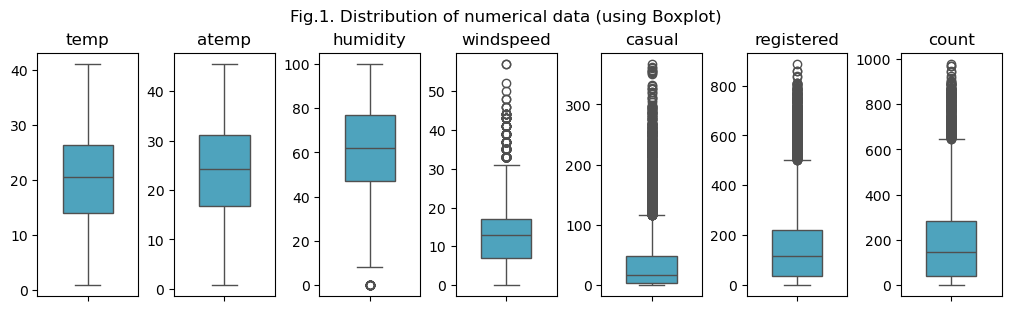

In [20]:
# Distribution of nuermical data (Boxplot)
num_cols = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']

plt.figure(figsize=(10,3), layout='constrained')
plt.suptitle('Fig.1. Distribution of numerical data (using Boxplot)')
for i , col in enumerate(num_cols, start=1):
    plt.subplot(1, 7, i)
    sns.boxplot(data= df, y=col, color=single_color, width=0.5)
    plt.ylabel('')
    plt.title(col)
plt.show()

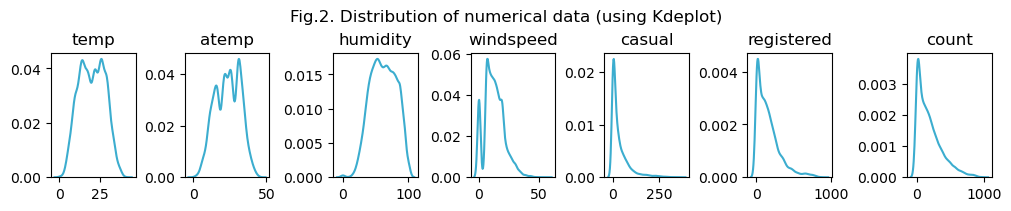

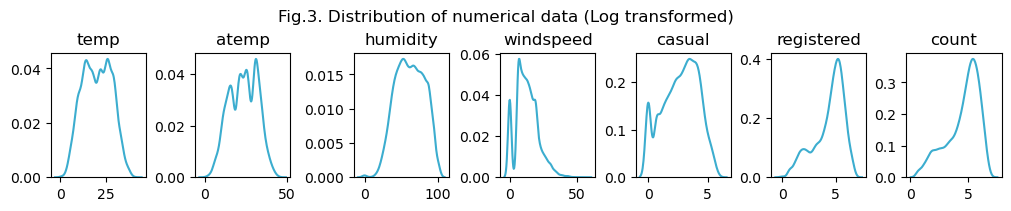

In [21]:
# Distribution of numerical data (Kdeplot)
plt.figure(figsize=(10, 2), layout='constrained')
plt.suptitle('Fig.2. Distribution of numerical data (using Kdeplot)')
for i, col in enumerate(num_cols, start=1):
    plt.subplot(1, 7, i)
    sns.kdeplot(data=df, x=col, color=single_color)
    plt.ylabel('')
    plt.xlabel('')
    plt.title(col)

# dataset copy
df_logged = df.copy()

# Log transformed values
df_logged['casual'] = np.log1p(df_logged['casual'])
df_logged['registered'] = np.log1p(df_logged['registered'])
df_logged['count'] = np.log1p(df_logged['count'])

# Log tranformed value distribution plot (Kdeplot)
plt.figure(figsize=(10, 2), layout='constrained')
plt.suptitle('Fig.3. Distribution of numerical data (Log transformed)')
for i, col in enumerate(num_cols, start=1):
    plt.subplot(1, 7, i)
    sns.kdeplot(data=df_logged, x=col, color=single_color)
    plt.ylabel('')
    plt.xlabel('')
    plt.title(col)

**Insights**
* Timeframe of the dataset is from 1 January 2011 till 19 December 2012.
* Seasons are equally distributed in the dataset.
* Clear weather condition dominates the data.
* Figure 1 Boxplot clearly indicates that windspeed, casual, registered and count columns contains outliers.
* large number of the outliers represents that bikes demand is heavy on special days or peak hours.
* Log transformation used on columns like casual, registered and count to cater the impact of skewness. Hence Kdeplot in figure 8 shows distribution of values which is not skewed.

Note: Log Transformation does not impact the result of analysis.

##### **Bi-variate Analysis**

Target variable: count

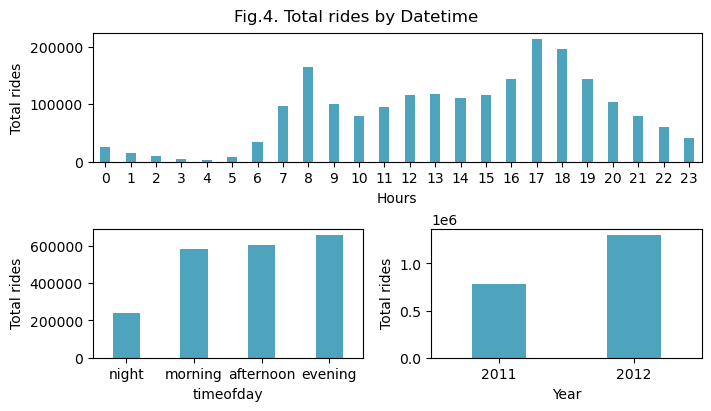

In [25]:
# Rental bikes demand Vs Datetime
plt.figure(figsize=(7, 4), layout='constrained')
plt.suptitle('Fig.4. Total rides by Datetime')
plt.subplot(2, 2, (1, 2))
sns.barplot(data=df, x=df['datetime'].dt.hour , y='count',
           color=single_color, width=0.4, estimator='sum', errorbar=None)
plt.xlabel('Hours')
plt.ylabel('Total rides')

plt.subplot(2, 2, 3)
sns.barplot(data=df, x='timeofday', y='count',
           color=single_color, width=0.4, estimator='sum', errorbar=None)
plt.ylabel('Total rides')

plt.subplot(2, 2, 4)
sns.barplot(data=df, x=df['datetime'].dt.year, y='count',
           color=single_color, width=0.4, estimator='sum', errorbar=None)
plt.ylabel('Total rides')
plt.xlabel('Year')
plt.show()

In [26]:
# Column name of categorical data
cate_cols = ['season', 'weather', 'holiday', 'workingday']

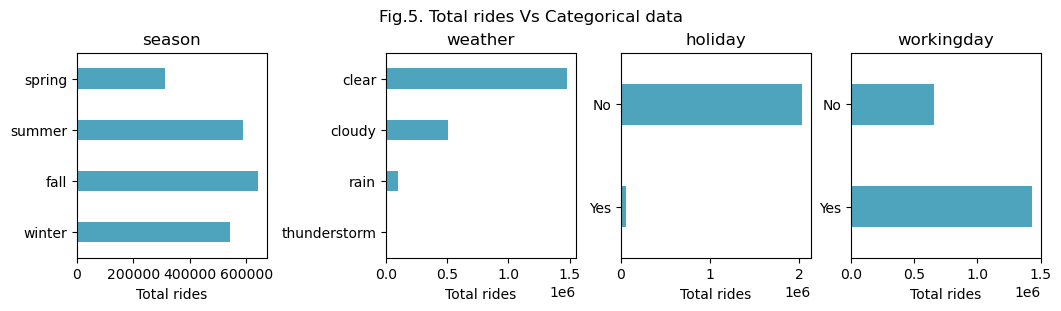

In [27]:
# Total rides Vs Categorical data
plt.figure(figsize=(10.5, 3), layout='constrained')
plt.suptitle('Fig.5. Total rides Vs Categorical data')
for i , col in enumerate(cate_cols, start= 1):
    plt.subplot(1, 4, i)
    sns.barplot(data=df, y=col, x='count', estimator='sum', errorbar=None, width=0.4, color=single_color)
    plt.xlabel('Total rides')
    plt.ylabel('')
    plt.title(col)

In [28]:
# Column name of numerical features
num_cols_minus_targets = num_cols[:-3]

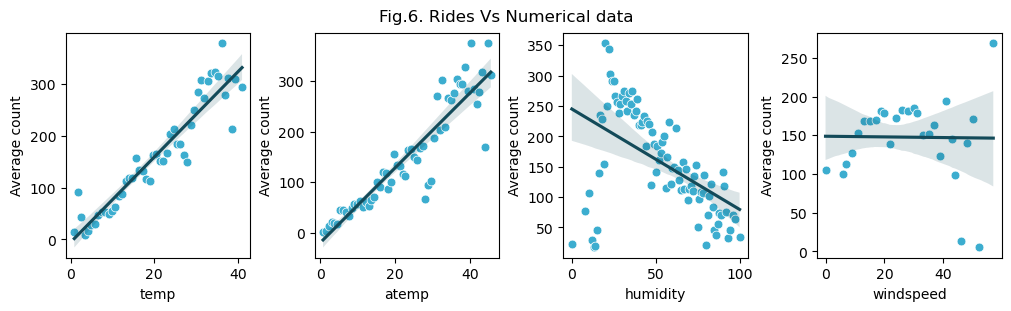

In [29]:
# Total rides Vs Numerical data
plt.figure(figsize=(10, 3), layout='constrained')
plt.suptitle('Fig.6. Rides Vs Numerical data')
for i , col in enumerate(num_cols_minus_targets, start=1):
    plt.subplot(1, 4, i)
    table_for_scatter= df.groupby(col)['count'].median().reset_index()
    sns.scatterplot(data=table_for_scatter, x=col, y='count', s=40, color=single_color)
    sns.regplot(data=table_for_scatter, x=col, y='count', scatter=False, color=yulu_palette[-1])
    plt.ylabel('Average count')


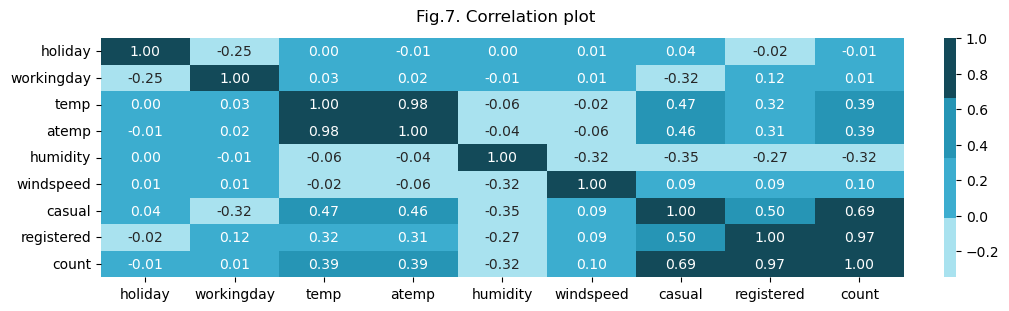

In [30]:
# Correlation plot
data_for_corr_plot = df.copy()

# Table
data_for_corr_plot['workingday'] = data_for_corr_plot['workingday'].map({'Yes':1, 'No':0})
data_for_corr_plot['holiday'] = data_for_corr_plot['holiday'].map({'Yes':1, 'No':0})
data_for_corr_plot = data_for_corr_plot.select_dtypes(include='number')

# Correlation plot
plt.figure(figsize=(10, 3), layout='constrained')
plt.suptitle('Fig.7. Correlation plot')
sns.heatmap(data= data_for_corr_plot.corr(), annot=True, cmap=yulu_palette, fmt='.2f')
plt.show()

**Insights**
* Figure 4 provides very useful information that maximum rides has been booked in the evening specially between 5:00PM and 6:00PM. Hourly plot also depict spikes in bikes demand around 8:00AM in the morning giving clear indication of office hours.
* In 2012 bikes demand got almost doubled in comparison to previous year.
* Figure 5 depicts that customers book electric bikes dominent in clear weather.
* Significantly very less number of rides booked on holidays.
* Months such as September, October, November reported highest number of rides booked, followed by summer season.
* Scatterplot vs Regression line in figure 6 represent strong positive relationship between rides booked and temperature. On the other hand, humidity show negative relationship with the rides demand. This depict in figure 6 clearly report customer does not prefer using bikes in low temperature and high humidity.
* Correlation plot suggest the association of numerical data. In the figure 7 depicts that casual rides count is inversely related to the working day, indicating casual rides are more booked on non working days.

Note: Through correlation plot we can see the 'temperature' and 'feel like temperature' are strongily correlated to each other, to avoid problem of multicolineariy 'atemp' column has been removed from the dataset.

In [32]:
# Drop atemp column
df = df.drop('atemp', axis =1)
df_logged = df_logged.drop('atemp', axis=1)

##### **Multi-variate Analysis**

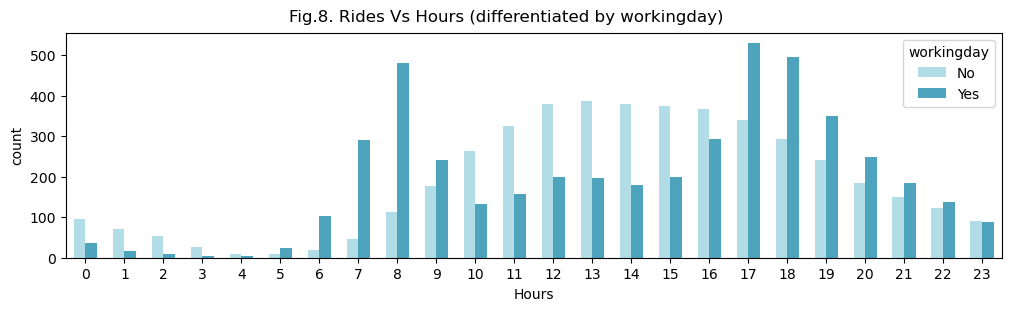

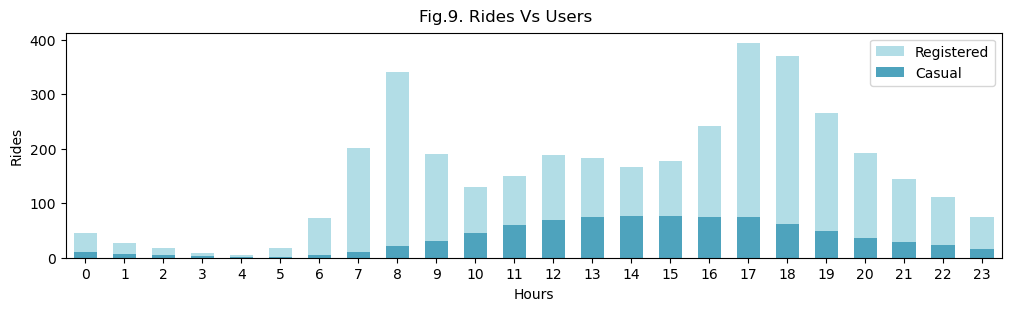

In [34]:
# Rides Vs hours (differentiated by working day)
plt.figure(figsize=(10, 3), layout='constrained')
plt.suptitle('Fig.8. Rides Vs Hours (differentiated by workingday)')
sns.barplot(x=df['datetime'].dt.hour, y=df['count'], hue=df['workingday'], errorbar=None, palette=yulu_palette[:2],
           width=0.6)
plt.xlabel('Hours')


# Rides Vs datetime (differentiated by usertype)
plt.figure(figsize=(10, 3), layout='constrained')
plt.suptitle('Fig.9. Rides Vs Users')
sns.barplot(x=df['datetime'].dt.hour, y=df['registered'], color=yulu_palette[0], width=0.6, errorbar=None,
            label='Registered')
plt.xlabel('Hours')
sns.barplot(x=df['datetime'].dt.hour, y=df['casual'],  color=yulu_palette[1], width=0.6, errorbar=None,
           label='Casual')
plt.xlabel('Hours')
plt.ylabel('Rides')
plt.legend()
plt.show()

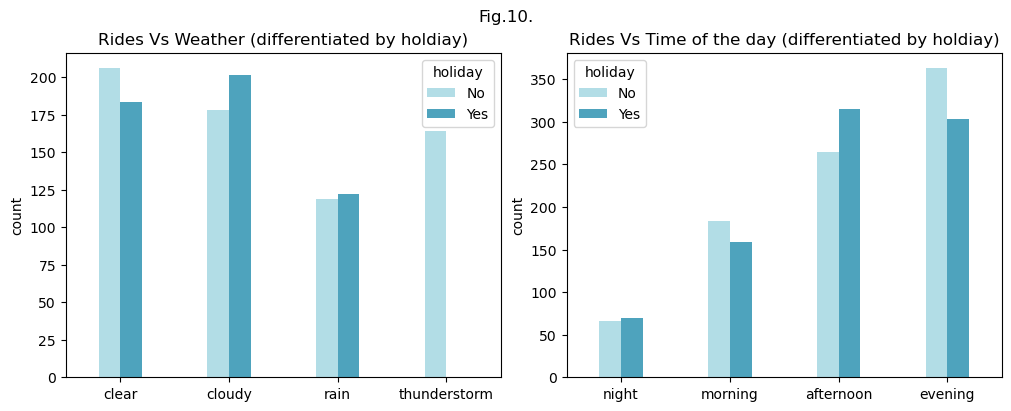

In [35]:
# Rides Vs weather (differentiated by holiday)
plt.figure(figsize=(10,4), layout='constrained')
plt.suptitle('Fig.10.')
plt.subplot(1, 2, 1)
sns.barplot(data=df , x='weather', y='count', hue='holiday', errorbar=None,
           width=0.4, palette=yulu_palette[:2])
plt.xlabel('')
plt.title('Rides Vs Weather (differentiated by holdiay)')

# Rides Vs Timeofday (differentiated by holiday)
plt.subplot(1, 2, 2)
sns.barplot(data=df , x='timeofday', y='count', hue='holiday', errorbar=None,
           width=0.4, palette=yulu_palette[:2])
plt.xlabel('')
plt.title('Rides Vs Time of the day (differentiated by holdiay)')
plt.show()

**Insights**
* Figure 8 shows huge spike during office hours at 8:00AM and 5:00PM. Also the figure depicts stable demand for electric bikes in the afternoon on non-working day.
* Casual customers book rides mostly during the afternoon and evening. And the customers who book during the office hours are dominantly the registered ones.
* Customers enjoy rides in cloudy weather on holidays as spike showen in figure 10.

In [37]:
# Round up df_logged
df_logged = df_logged.round(2)

#### **Inferential Statistics**

##### **Two Sample T-Test**

Function for two sample T-test

In [41]:
# function to run 2 sample T test 
def two_sample_ttest(h0, h1, feature, var1, var2, target='count', tail_type='two-sided', confi=0.95):
    print(f'Null Hypothesis -> {h0}')
    print(f'Alternate Hypothesis -> {h1}')
    print('')
    sample1 = df_logged[df_logged[feature] == var1][target]
    sample2 = df_logged[df_logged[feature] == var2][target]
    print(f'Sample 1 -> {feature}: {var1}, {sample1.mean().round(2)}')
    print(f'Sample 2 -> {feature}: {var2}, {sample2.mean().round(2)}')
    pct_diff = abs(((sample1.mean() - sample2.mean()) / sample2.mean()) * 100)
    print(f'Percentage difference -> {pct_diff:.2f}%')
    print('')
    alpha = 1 - confi
    t_statistic, pvalue = ttest_ind(sample1, sample2, alternative=tail_type)
    print(f'T-Test at confidence interval of {confi*100}%')
    if pvalue < alpha: 
        print('pvalue:', pvalue.round(3), 'Reject the null hypothesis.')
        print(f'We have sufficient evidence to conclude that: {h1}')
    else:
        print('pvalue:', pvalue.round(3), 'Failed to reject the null hypothesis.')
        print(f'We do not have sufficient evidence to conclude that: {h1}')
    print('-'*100)
    print('-'*100)
    print('')

Effect of working day on rides booked

In [43]:
# Effect of working day on average rides booked per hour (at 95% confidence level)
print('Effect of working day on rides booked per hour')
two_sample_ttest(
    'Multiplicative difference between rides booked on working day and non-working day are same.',
    'Multiplicative difference between rides booked on working day and non-working day are not same.',
    'workingday', 'Yes', 'No')

# Effect of working day on average rides booked per hour by registered users (at 95% confidence level)
print('Effect of working day on rides booked per hour by registered users')
two_sample_ttest(
    'Multiplicative difference between rides booked on working day and non-working day by registered users are same.',
    'Multiplicative difference between rides booked on working day and non-working day by registered users are not same.',
    'workingday', 'Yes', 'No', target='registered')

# Effect of working day on average rides booked per hour by casual users (at 95% confidence level)
print('Effect of working day on rides booked per hour by casual users')
two_sample_ttest(
    'Multiplicative difference between rides booked on working day and non-working day by casual users are same.',
    'Multiplicative difference between rides booked on working day and non-working day by casual users are not same.',
    'workingday', 'Yes', 'No', target='casual')

Effect of working day on rides booked per hour
Null Hypothesis -> Multiplicative difference between rides booked on working day and non-working day are same.
Alternate Hypothesis -> Multiplicative difference between rides booked on working day and non-working day are not same.

Sample 1 -> workingday: Yes, 4.58
Sample 2 -> workingday: No, 4.62
Percentage difference -> 1.01%

T-Test at confidence interval of 95.0%
pvalue: 0.111 Failed to reject the null hypothesis.
We do not have sufficient evidence to conclude that: Multiplicative difference between rides booked on working day and non-working day are not same.
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Effect of working day on rides booked per hour by registered users
Null Hypothesis -> Multiplicative difference between rides booked on working day and non-working day by register

Effect of holiday on rides booked

In [45]:
# Effect of Holiday day on average rides booked per hour (at 95% confidence level)
print('Effect of holiday on average rides booked per hour')
two_sample_ttest(
    'Multiplicative difference between rides booked on holiday day and non-holiday day are same.',
    'Multiplicative difference between rides booked on holiday day and non-holiday day are not same.',
    'holiday', 'Yes', 'No')

# Effect of Holiday day on average rides booked per hour by registered users (at 95% confidence level)
print('Effect of holiday on average rides booked per hour by registered user')
two_sample_ttest(
    'Multiplicative difference between rides booked on holiday day and non-holiday day by registered users are same.',
    'Multiplicative difference between rides booked on holiday day and non-holiday day by registered users are not same.',
    'holiday', 'Yes', 'No', target='registered')

# Effect of Holiday on average rides booked per hour by casual users
print('Effect of holiday on average rides booked per hour by casual users')
two_sample_ttest(
    'Multiplicative difference between rides booked on holiday and non-holiday by casual users are same.',
    'Multiplicative difference between rides booked on holiday and non-holiday by casual users are not same.',
    'holiday', 'Yes', 'No', target='casual')

Effect of holiday on average rides booked per hour
Null Hypothesis -> Multiplicative difference between rides booked on holiday day and non-holiday day are same.
Alternate Hypothesis -> Multiplicative difference between rides booked on holiday day and non-holiday day are not same.

Sample 1 -> holiday: Yes, 4.58
Sample 2 -> holiday: No, 4.59
Percentage difference -> 0.23%

T-Test at confidence interval of 95.0%
pvalue: 0.897 Failed to reject the null hypothesis.
We do not have sufficient evidence to conclude that: Multiplicative difference between rides booked on holiday day and non-holiday day are not same.
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Effect of holiday on average rides booked per hour by registered user
Null Hypothesis -> Multiplicative difference between rides booked on holiday day and non-holiday day by registe

##### **One way ANOVA Test / Kruskal Test**

Assumptions of one way ANOVA test:

Function to check the equal variance of samples (Levene Test)

In [49]:
# Levene test to check if the samples has equal variance
def test_to_check_equal_variance(feature, target='count', confi=0.95):
    variables = df_logged[feature].unique()

    samples = []
    for _ in variables:
        sample = df_logged[df_logged[feature] == _][target]
        samples.append(sample)
    # Levene Test
    alpha = 1 - confi
    test_statistic, pvalue = levene(*samples)
    if pvalue < alpha:
        print(f'pvalue: {pvalue.round(3)}, Samples doesnot have equal variance.')
    else:
        print(f'pvalue: {pvalue.round(3)}, Samples has equal variance.')

Levene test on season

In [51]:
# Perform Levene test on season
test_to_check_equal_variance('season')

pvalue: 0.0, Samples doesnot have equal variance.


Function to check the normality of the data

In [53]:
# Shapiro Test to check the normality of the data
def test_to_check_data_normality(feature, target='count', confi=0.95):
    variables = df_logged[feature].unique()

    for _ in variables:
        print(f'{_}:')
        sample = df_logged[df_logged[feature] == _][target]
        test_statistics, pvalue = shapiro(sample)
        alpha = 1 - confi
        if pvalue < alpha:
            print(f'pvalue: {pvalue.round(3)}, {feature} variable {_} does not follow normal distribution.')
        else:
            print(f'pvalue: {pvalue.round(3)}, {feature} variable {_} does follow normal distribution.')

Shapiro Test performed on season column

In [55]:
# Perform Shapiro test to check normality of the data
test_to_check_data_normality('season')

spring:
pvalue: 0.0, season variable spring does not follow normal distribution.
summer:
pvalue: 0.0, season variable summer does not follow normal distribution.
fall:
pvalue: 0.0, season variable fall does not follow normal distribution.
winter:
pvalue: 0.0, season variable winter does not follow normal distribution.


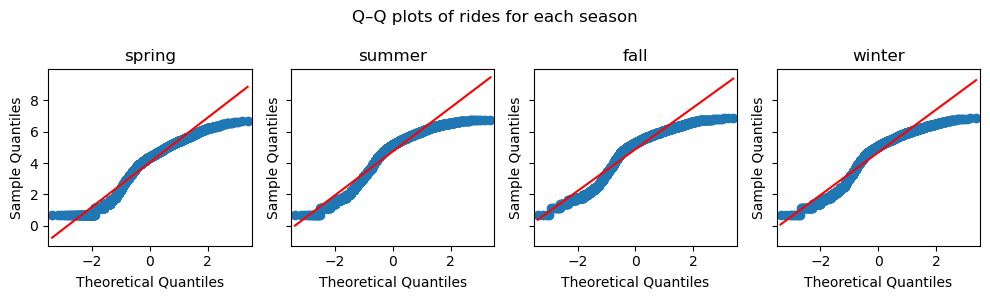

In [56]:
# Q-Q plot for visually see normality of the dataset

fig, axes = plt.subplots(1, df_logged['season'].nunique(), figsize=(10, 3), sharey=True)

for i, col in enumerate(df_logged['season'].unique(), start=0):
    table_for_qqplot = df_logged[df_logged['season'] == col]['count']

    qqplot(table_for_qqplot, line='s', ax=axes[i])

    axes[i].set_title(col)
plt.suptitle("Q–Q plots of rides for each season")
plt.tight_layout()
plt.show()

Above qqplot shows no season follow normal distribution.

Function to test one way ANOVA or kruskal test

In [59]:
# Function to run one way ANOVA test or Kruskal test
def one_way_anova_test_or_kruskal(h0, h1, feature, test, target='count', confi=0.95, tail_type='two-sided'):
    print(f'Null Hypothesis -> {h0}')
    print(f'Alternate Hypothesis -> {h1}')
    print('')
    variables = df_logged[feature].unique()

    samples = []
    for _ in variables:
        sample = df_logged[df_logged[feature] == _][target]
        print(f'Sample -> {feature}:{_}, {sample.mean().round(2)}')
        samples.append(sample)
    # Test
    if test == 'ANOVA':
        test_statistic, pvalue = f_oneway(*samples)
    elif test == 'Kruskal':
        test_statistic, pvalue = kruskal(*samples)
    print('')
    print(f'{test} test at confidence level of {confi * 100}%')
    alpha = 1 - confi
    if pvalue < alpha:
        print(f'pvalue: {pvalue.round(3)} Reject the null hypothesis.')
        print(f'We have sufficient evidence to conclude that: {h1}')
    else:
        print(f'pvalue: {pvalue.round(3)} Failes to reject the null hypothesis.')
        print(f'We do not have sufficient evidence to conclude that: {h1}')
    print('-'*100)
    print('-'*100)
    print('')

Kruskal test performed on season column

In [61]:
# Seasonality effect on rides booked
one_way_anova_test_or_kruskal(
    'Number of electric bikes rented are similar in different seasons',
    'Number of electric bikes rented are not similar in different seasons.',
    'season', 'Kruskal')

Null Hypothesis -> Number of electric bikes rented are similar in different seasons
Alternate Hypothesis -> Number of electric bikes rented are not similar in different seasons.

Sample -> season:spring, 4.05
Sample -> season:summer, 4.74
Sample -> season:fall, 4.89
Sample -> season:winter, 4.68

Kruskal test at confidence level of 95.0%
pvalue: 0.0 Reject the null hypothesis.
We have sufficient evidence to conclude that: Number of electric bikes rented are not similar in different seasons.
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



two sample T-test conducted on season column pairwise

In [63]:
# The above Kruskal test confirms that average rides booked in four season are not same.
# Therefore seperate two sample T-test is required

# Spring and Summer
print('Effect of spring season and summer season on rides booked.')
two_sample_ttest(
    'Multiplicative difference between rides booked in spring season and summer season is same.',
    'Multiplicative difference between rides booked in spring season and summer season is not same.',
    'season','spring', 'summer')

# Spring and Fall
print('Effect of spring season and fall season on rides booked.')
two_sample_ttest(
    'Multiplicative difference between rides booked in spring season and fall season is same.',
    'Multiplicative difference between rides booked in spring season and fall season is not same.',
    'season','spring', 'fall')

# Spring and Winter
print('Effect of spring season and winter season on rides booked.')
two_sample_ttest(
    'Multiplicative difference between rides booked in spring season and winter season is same.',
    'Multiplicative difference between rides booked in spring season and winter season is not same.',
    'season','spring', 'winter')

# Summer and Fall
print('Effect of summer season and fall season on rides booked.')
two_sample_ttest(
    'Multiplicative difference between rides booked in summer season and fall season is same.',
    'Multiplicative difference between rides booked in summer season and fall season is not same.',
    'season','summer', 'fall')

# Summer and Winter
print('Effect of summer season and winter season on rides booked.')
two_sample_ttest(
    'Multiplicative difference between rides booked in summer season and winter season is same.',
    'Multiplicative difference between rides booked in summer season and winter season is not same.',
    'season','summer', 'winter')

# Fall and Winter
print('Effect of fall season and winter season on rides booked.')
two_sample_ttest(
    'Multiplicative difference between rides booked in summer fall and winter season is same.',
    'Multiplicative difference between rides booked in summer fall and winter season is not same.',
    'season','fall', 'winter')

Effect of spring season and summer season on rides booked.
Null Hypothesis -> Multiplicative difference between rides booked in spring season and summer season is same.
Alternate Hypothesis -> Multiplicative difference between rides booked in spring season and summer season is not same.

Sample 1 -> season: spring, 4.05
Sample 2 -> season: summer, 4.74
Percentage difference -> 14.49%

T-Test at confidence interval of 95.0%
pvalue: 0.0 Reject the null hypothesis.
We have sufficient evidence to conclude that: Multiplicative difference between rides booked in spring season and summer season is not same.
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Effect of spring season and fall season on rides booked.
Null Hypothesis -> Multiplicative difference between rides booked in spring season and fall season is same.
Alternate Hypothesis -> 

Effect of weather on average rides booked per hour

Assumption of ANOVA test

Levene test on weather

In [67]:
df_logged = df_logged[~(df_logged['weather'] == 'thunderstorm')]

Levene test on weather

In [69]:
# Levene test on weather
test_to_check_equal_variance('weather')

pvalue: 0.645, Samples has equal variance.


Shapiro test on weather column to check the normaility of the data

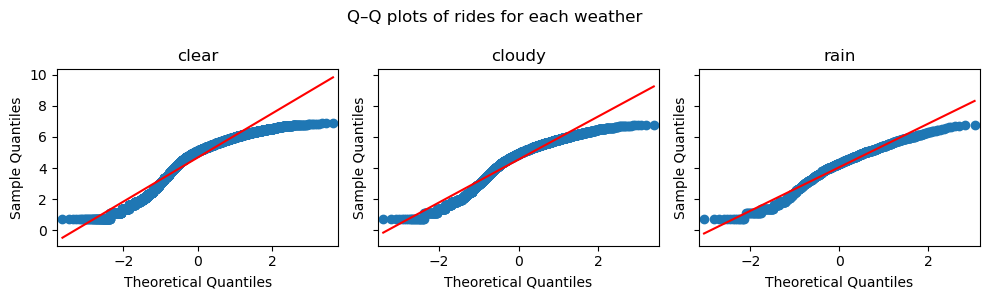

In [71]:
# Q-Q plot for visually see normality of the dataset

fig, axes = plt.subplots(1, df_logged['weather'].nunique(), figsize=(10, 3), sharey=True)

for i, col in enumerate(df_logged['weather'].unique(), start=0):
    table_for_qqplot = df_logged[df_logged['weather'] == col]['count']

    qqplot(table_for_qqplot, line='s', ax=axes[i])

    axes[i].set_title(col)
plt.suptitle("Q–Q plots of rides for each weather")
plt.tight_layout()
plt.show()

In [72]:
# Weather effect on rides booked
one_way_anova_test_or_kruskal(
    'Number of electric bikes rented are similar in different weather condition',
    'Number of electric bikes rented are not similar in different weather condition.',
    'weather', 'Kruskal')

Null Hypothesis -> Number of electric bikes rented are similar in different weather condition
Alternate Hypothesis -> Number of electric bikes rented are not similar in different weather condition.

Sample -> weather:clear, 4.67
Sample -> weather:cloudy, 4.55
Sample -> weather:rain, 4.05

Kruskal test at confidence level of 95.0%
pvalue: 0.0 Reject the null hypothesis.
We have sufficient evidence to conclude that: Number of electric bikes rented are not similar in different weather condition.
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------



In [73]:
# The above Kruskal test confirms that average rides booked in four season are not same.
# Therefore seperate two sample T-test is required

# Clear and Cloudy weather
print('Effect of clear and cloudy weather on ride booking.')
two_sample_ttest('Multiplicative difference between rides booked in clear weather and cloudy weather is same.',
                 'Multiplicative difference between rides booked in clear weather and cloudy weather is not same.',
                'weather', 'clear', 'cloudy')

# Clear and Rain weather
print('Effect of clear and rain weather on ride booking.')
two_sample_ttest('Multiplicative difference between rides booked in clear weather and rain weather is same.',
                 'Multiplicative difference between rides booked in clear weather and rain weather is not same.',
                'weather', 'clear', 'rain')

# Cloudy and Rain weather
print('Effect of cloudy and rain weather on ride booking.')
two_sample_ttest('Multiplicative difference between rides booked in cloudy weather and rain weather is same.',
                 'Multiplicative difference between rides booked in cloudy weather and rain weather is not same.',
                'weather', 'cloudy', 'rain')

Effect of clear and cloudy weather on ride booking.
Null Hypothesis -> Multiplicative difference between rides booked in clear weather and cloudy weather is same.
Alternate Hypothesis -> Multiplicative difference between rides booked in clear weather and cloudy weather is not same.

Sample 1 -> weather: clear, 4.67
Sample 2 -> weather: cloudy, 4.55
Percentage difference -> 2.83%

T-Test at confidence interval of 95.0%
pvalue: 0.0 Reject the null hypothesis.
We have sufficient evidence to conclude that: Multiplicative difference between rides booked in clear weather and cloudy weather is not same.
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------

Effect of clear and rain weather on ride booking.
Null Hypothesis -> Multiplicative difference between rides booked in clear weather and rain weather is same.
Alternate Hypothesis -> Multiplica

Chi Square test on season and weather

In [75]:
# Chi-square test to check the dependency of season and weather
chi_table = pd.crosstab(index=df_logged['season'], columns=df_logged['weather'])

print('''
Null Hypothesis: Season and weather are independent of each other.
Alternate Hypothesis: Season and weather are not independent of each other.
''')

test_statistic, pvalue, dof, expected = chi2_contingency(chi_table)

# Confidence level 95%
alpha = 1 - 0.95

if pvalue < alpha:
    print(f'pvalue: {pvalue.round(3)}, Reject null hypothesis.')
else:
    print(f'pvalue: {pvalue.round(3)}, Failed to reject null hypothesis.')


Null Hypothesis: Season and weather are independent of each other.
Alternate Hypothesis: Season and weather are not independent of each other.

pvalue: 0.0, Reject null hypothesis.


**Insights**  
Inferential statistics is inclusion of probability in statistics to verify if the pattern shown in the data is solid or just noise.
* After using two sample T-test to determine the effect of the working day on average rides booked, results depicts no significant difference to highlight the effect.
* Similar two sample T-Test has been conducted to understand the effect of holiday on average rides booked per hour. However the result of the test performed at 95% of confidence level dipicted no significant effect of holiday on booking.
* Two sample T-Test backed the finding that registered users booked bikes on working day 2% more than the non-working day.
* Through two sample t test we can estimate that 27% more rides booked were by casual users on non-working day.
* Similarly T-Test has been used on holiday to determine the significance of rides booked by casual users on holidays and test results that 9% more rides were booked by casual users on holiday.
* Levene test, Shapiro test are conducted to check the assumption of ANOVA test. On the basis of the result of the test we have kruskal test to check the effect of season on average rides booked per hours.
* Kruskal test with two sample t test concludes that spring season has lowest demand whereas fall season is significantly highest. summer and winter season has statistically similar demand.
* Similarly, all the assumption has been performed on weather column as well, and through the result we can conclude the sample groups does have equal variance but are not normally distributed, therefore the check the significance of weather condition on rides booked per hour Kruskal test has been conducted. Followed by two sample T-test on different sample groups in weather condition we can found maximum demand of electric bikes in clear weather condition.
* Chi-square test of dependency confirms that season and weather are associated to each other.

#### **Recommendations**

**Rides distribution**
* Deploy maximum bikes during peak hours (8 AM and 5-6 PM) on working days
* Maintain higher availability in afternoons and evenings on weekends for casual users
* Reduce fleet during late night/early morning hours (low demand period)

**Registered users stretegies**
* Focus on reliability during office commute hours
* Offer corporate partnerships and subscription plans
* Ensure consistent availability on working days

**Casual users stretegies**
* Promote weekend and holdiday usage through offers.
* Develop tourist friendly routes

**Seasonlity effect on rides**
* Conduct discount offer rides during spring season.
* Deploy sufficient rides during fall season, increase pricing as well.

**Weather condition effects**
* Use promotional notifications during cloudy weather to engage more casual customers.
* Perform app maintainence activity in heavy rain, since customers count would be extremely low.

#### **Conclusion**

Yulu’s electric bike demand doubled within one year, indicating a strong positive market response. A detailed analysis of the dataset shows that the time of day plays a pivotal role in driving revenue. Maximum demand occurs during office hours, primarily from registered users. In contrast, casual users tend to prefer riding in the afternoons, on weekends, and on holidays. The analysis also reveals lower booking volumes during low temperatures, rainy weather, and high humidity. Overall, the study clearly highlights the strong dependence of electric bike demand on season, weather, and time of day.

In [81]:
# End